# Using Indigo for DC Removal in X-Space MPI

Based on Konkle et al. [A Convex Formulation for Magnetic Particle Imaging X-Space Reconstruction](https://doi.org/10.1371/journal.pone.0140137).

## Load example image

Populating the interactive namespace from numpy and matplotlib


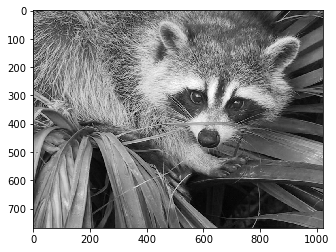

In [1]:
%pylab inline

import logging
import argparse
import numpy as np
from scipy import misc
import scipy.sparse as spp
from contexttimer import Timer

img = misc.face()
img = img[:,:,0] # select one color channel
img = img.astype(np.complex64) # change datatype

plt.imshow(abs(img), cmap='gray', interpolation='none')

## Generate synthetic pFOV data

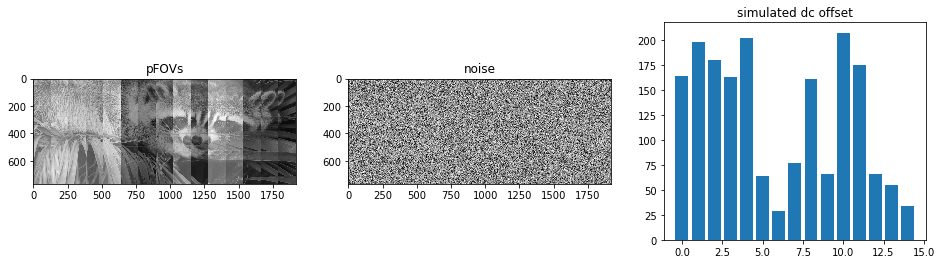

In [2]:
x,z = img.shape
p = width = 128
s = overlap = 32
g = gap = p-2*s
snr = 10

pfovs = np.array([img[:,c:c+p] for c in range(0,z-g,g)])

img_dc = np.mean(abs(img))
dc_offsets = 2*np.random.rand(len(pfovs)) * img_dc
pfovs += dc_offsets[:,None,None]

noise = (np.random.rand(*pfovs.shape) + 1j*np.random.rand(*pfovs.shape)) / snr
pfovs += noise

npf, px, pz = pfovs.shape

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(16,4))
ax0.set_title("pFOVs")
ax0.imshow( abs(pfovs).transpose(1,0,2).reshape((x,-1)), cmap='gray', interpolation='nearest' )
ax1.set_title("noise")
ax1.imshow( abs(noise).transpose(1,0,2).reshape((x,-1)), cmap='gray', interpolation='nearest' )
ax2.set_title("simulated dc offset")
ax2.bar(range(len(dc_offsets)), dc_offsets)
plt.show()

## Construct Operators

In [3]:
# instantiate backend
from indigo.backends import get_backend
from indigo.transforms import *

B = get_backend('customgpu') # or numpy, cuda, etc.

# construct segmentation operator
indices = np.arange(img.size).reshape(img.shape)
S_shape = (pfovs.size, img.size)
data = np.ones(pfovs.size, dtype=np.complex64)
rows = np.arange(pfovs.size)
cols = np.array([indices[:,c:c+p] for c in range(0,z-g,g)]).flatten()
SegOp = spp.coo_matrix((data, (rows,cols)), shape=S_shape)
S = B.SpMatrix(SegOp, name='segment')

# construct DC removal operator
D = B.KronI(npf*px, B.Eye(pz) - (1/pz)*B.One((pz,pz)))

# combine operators into forward model
A = D*S

# show operator tree
print(A.dump())

*segment, Product, (1474560, 786432), complex64
|   noname, KronI, (1474560, 1474560), complex64
|   |   +%s*%s*, Sum, (128, 128), complex64
|   |   |   noname, Eye, (128, 128), complex64
|   |   |   %s*%s*, Scale, (128, 128), complex64
|   |   |   |   %s*, Scale, (128, 128), complex64
|   |   |   |   |   noname, One, (128, 128), complex64
|   segment, SpMatrix, (1474560, 786432), complex64



## Solve via conjugate gradient

reconstruction took 143 ms


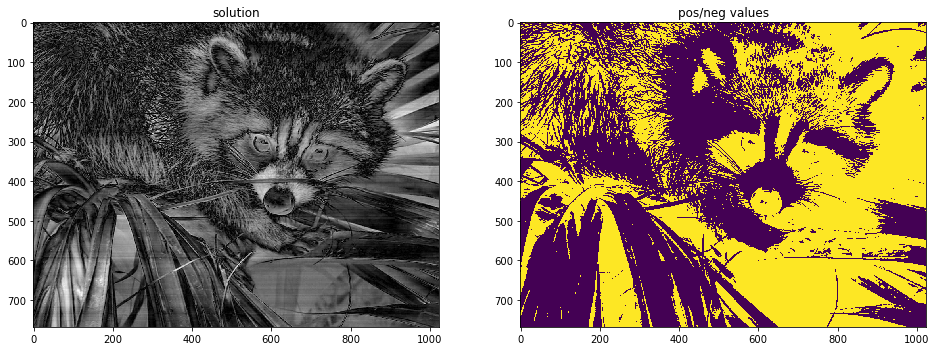

In [4]:
# reshape vectors into 2d fortran-ordered arrays
Y = pfovs.copy().reshape((1,-1)).T
X = np.zeros_like(img).reshape((1,-1)).T

# cg prep
AHy = A.H * Y
AHA = (A.H * A).optimize()

# reconstruct
with Timer() as t:
    B.cg(AHA, AHy, X, maxiter=20)

print("reconstruction took %d ms" % (t.elapsed*1000))

img_rec = X.T.reshape(img.shape)
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16,16))
ax0.set_title('solution')
ax0.imshow(abs(img_rec), cmap='gray', interpolation='none')
ax1.set_title('pos/neg values')
ax1.imshow(img_rec.real < 0)

## Solve via FISTA

reconstruction took 1276 ms


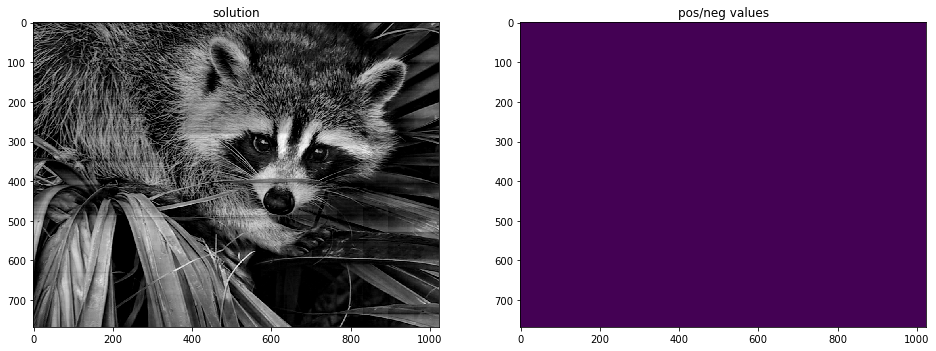

In [5]:
# reshape vectors into 2d fortran-ordered arrays
Y = pfovs.copy().reshape((1,-1)).T
X = np.zeros_like(img).reshape((1,-1)).T

AHy_d = B.copy_array(AHy)

def proxg(x_d, alpha):
    B.max(0, x_d)
    
def gradf(gf, x):
    # gf = AHA*x - AHy
    AHA.eval(gf, x)
    B.axpby(1, gf, -1, AHy_d)

alpha = 0.05
with Timer() as t:
    B.apgd(gradf, proxg, alpha, X, maxiter=200)

print("reconstruction took %d ms" % (t.elapsed*1000))

img_rec = X.T.reshape(img.shape)
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16,16))
ax0.set_title('solution')
ax0.imshow(abs(img_rec), cmap='gray', interpolation='none')
ax1.set_title('pos/neg values')
ax1.imshow(img_rec.real < 0)